# VGG-16 & VGG-19 (Functional API)

### Step 0: Imports and Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

2025-10-03 17:58:26.778317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759514306.964431      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759514307.017326      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Step 1: Load and Preprocess the data

In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# resize_layer = tf.keras.layers.Resizing(224,224)
# x_train = resize_layer(x_train)
# x_test = resize_layer(x_test)

# x_train = preprocess_input(x_train)
# x_test = preprocess_input(x_test)

# Flatten the targets
y_train = y_train.flatten()
y_test = y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Step 2: Define Model

In [3]:
# Load VGG Backbone
from tensorflow.keras.applications import VGG16

# Base 
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the Convolutional base
base_vgg16.trainable = False

I0000 00:00:1759514325.235598      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Build the Functional API model
inputs = tf.keras.Input(shape=(32,32,3))
x = tf.keras.layers.Resizing(224,224)(inputs)
x = preprocess_input(x)
x = base_vgg16(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_vgg16 = tf.keras.Model(inputs,outputs, name='VGG16_CIFAR10')

### Step 3: Compile Model

In [5]:
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Step 4: Train and Evaluate

In [6]:
history = model_vgg16.fit(
    x_train, y_train,
    validation_split=.1,
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10


I0000 00:00:1759514330.611605      99 service.cc:148] XLA service 0x7a377c00c810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759514330.612024      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759514330.968472      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759514339.424033      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 - 119s - 84ms/step - accuracy: 0.6901 - loss: 1.1149 - val_accuracy: 0.8472 - val_loss: 0.4680
Epoch 2/10
1407/1407 - 103s - 73ms/step - accuracy: 0.8327 - loss: 0.5197 - val_accuracy: 0.8644 - val_loss: 0.4089
Epoch 3/10
1407/1407 - 104s - 74ms/step - accuracy: 0.8751 - loss: 0.3841 - val_accuracy: 0.8748 - val_loss: 0.3947
Epoch 4/10
1407/1407 - 104s - 74ms/step - accuracy: 0.8986 - loss: 0.3029 - val_accuracy: 0.8750 - val_loss: 0.4005
Epoch 5/10
1407/1407 - 104s - 74ms/step - accuracy: 0.9135 - loss: 0.2603 - val_accuracy: 0.8792 - val_loss: 0.3942
Epoch 6/10
1407/1407 - 104s - 74ms/step - accuracy: 0.9252 - loss: 0.2225 - val_accuracy: 0.8796 - val_loss: 0.4312
Epoch 7/10
1407/1407 - 104s - 74ms/step - accuracy: 0.9335 - loss: 0.1998 - val_accuracy: 0.8840 - val_loss: 0.4596
Epoch 8/10
1407/1407 - 104s - 74ms/step - accuracy: 0.9429 - loss: 0.1677 - val_accuracy: 0.8884 - val_loss: 0.4502
Epoch 9/10
1407/1407 - 103s - 73ms/step - accuracy: 0.9486 - loss: 0.1565 - val_acc

### Step 5: Evaluate and visualize

In [7]:
loss, acc = model_vgg16.evaluate(x_test, y_test, verbose=0)
print(f'VGG16 CIFAR10 Test Accuracy:{acc}')

VGG16 CIFAR10 Test Accuracy:0.8833000063896179


### Step 6: Visualize

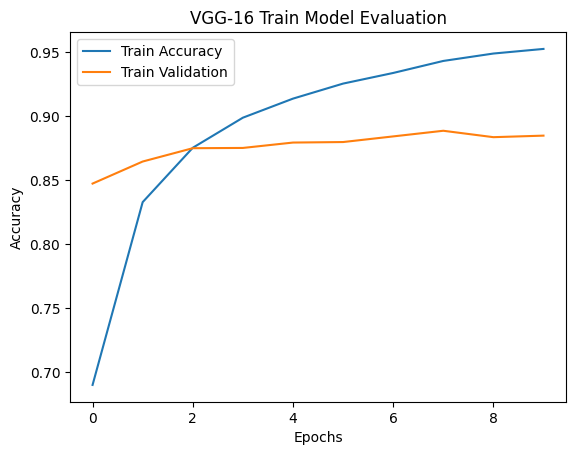

In [8]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Train Validation')
plt.xlabel('Epochs');plt.ylabel('Accuracy');plt.title('VGG-16 Train Model Evaluation');plt.legend();plt.show()

### Step 7: Prediction

In [ ]:
img = x_test[0]
img_resized = tf.image.resize(img,(224,224))
img_ready = tf.expand_dims(img_resized, axis=0)
img_ready = preprocess_input(img_ready)

pred = model_vgg16.predict(img_ready)
pred_label = np.argmax(pred, axis=1)[0]

print("Predicted:", class_names[pred_label])
print("True:", class_names[y_test[0]])

### Step 7: Notes 